In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from scipy.signal import savgol_filter

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec
from IPython.display import display, Math

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec
from IPython.display import display, Math
from sklearn.metrics import r2_score

from statistics import mean, median
from pylr2 import regress2

import seawater

from pylr2 import regress2

In [2]:

data_wc = pd.read_csv('../Dissertation_projects/Data/Stats_data_sets/data_wc.csv')

data_wc.loc[data_wc['pw_flux_doc'] > 25, 'pw_flux_doc'] = np.nan
data_wc['ratio_flux_2_stock'] = data_wc['pw_flux_doc'] / data_wc['doc_mol_per_m3_0_to_5cm']
data_wc['ratio_stock_2_flux'] = data_wc['doc_mol_per_m3_0_to_5cm'] / data_wc['pw_flux_doc']


n = 0.29
data_wc['Cox'] = data_wc['pw_flux_doc'] / 0.36
data_wc['Cox'] = data_wc['Cox'] ** (1/n)

data_wc['ratio_pw_flux_doc_2_cox'] = data_wc['pw_flux_doc'] / data_wc['Cox']

data_wc['ratio_doc_2_fet'] = data_wc['doc_mol_per_m3_0_to_5cm'] / data_wc['fet_mol_per_m3_0_to_25cm']
data_wc['ratio_oc_2_fet'] = data_wc['OC_mol_per_m3_0_to_5cm'] / data_wc['fet_mol_per_m3_0_to_5cm']


data_wc['group'] == "water_col"
data_wc['group']


# Define a function to assign group
def assign_group(df):
    max_depth_index = df['Depth'].idxmax()
    df.loc[df['Depth'] <= 5, 'group'] = 'Surface'
    df.loc[max_depth_index, 'group'] = 'BBL'
    return df

# Apply the function within groups
data_wc = data_wc.groupby(['Campaign', 'Location']).apply(assign_group).reset_index(drop=True)


data_wc['group'].unique()

data_wc['aou_ceq'] = data_wc['aou'] * .76 

data_wc_all = data_wc


df_note = pd.read_csv('../Dissertation_projects/Data/Stats_data_sets/Station_summary.csv',sep=',', index_col=0)
df_note['Date'] = pd.to_datetime(df_note['date'])
note_join = df_note['rgn']


data_wc_all['code'] = data_wc_all['Location'] + '_' + data_wc_all['Campaign']
data_wc_all.index = data_wc_all['code']
data_wc_all['rgn'] = note_join

data_wc_bbl = data_wc_all[data_wc_all['group'] == "BBL"]
data_wc_surf = data_wc_all[data_wc_all['group'] == "Surface"]
data_wc = data_wc_all[data_wc_all['group'] == "water_col"]

data_wc_hsal = data_wc[data_wc['sal'] >= 33]
data_wc_lsal = data_wc[data_wc['sal'] <= 33]

data_bbl_hsal = data_wc_bbl[data_wc_bbl['sal'] >= 33]
data_bbl_lsal = data_wc_bbl[data_wc_bbl['sal'] <= 33]

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_3380\3291104000.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_wc = data_wc.groupby(['Campaign', 'Location']).apply(assign_group).reset_index(drop=True)


In [3]:
def xyplotcolor(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = data_wc_all[z_var].min()
    vmax = data_wc_all[z_var].max()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)

    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color, s=100, data=data, ax=axes, legend=False , vmin=vmin, vmax=vmax)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel + f'R\u00B2: {score:.2f}', size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()
    

In [4]:

def tls_regression(x, y):
    # Add a column of ones to x to represent the intercept
    X = np.column_stack((np.ones(len(x)), x))

    # Compute the SVD of X
    U, s, Vt = np.linalg.svd(X, full_matrices=False)

    # Compute the pseudo-inverse of X
    X_inv = np.dot(Vt.T / s, U.T)

    # Compute the TLS regression coefficients
    beta_tls = np.dot(X_inv, y)

    return beta_tls

# Assuming you have your data x_var and y_var
x_var = data_wc_hsal['aou_ceq']
y_var = data_wc_hsal['NPOC_uM']

# Perform TLS regression
beta_tls = tls_regression(x_var, y_var)

# Print coefficients
intercept_tls, slope_tls = beta_tls


from pylr2 import regress2
results = regress2(x_var, y_var, _method_type_2="reduced major axis")

results

print("Intercept (TLS):", results['intercept'])
print("Slope (TLS):", results['slope'])
print("R2 (TLS):", results['r']*results['r'])

Cal_slope = results['slope']

Intercept (TLS): 104.78897431681483
Slope (TLS): -0.5685705239909127
R2 (TLS): 0.32642277668959097


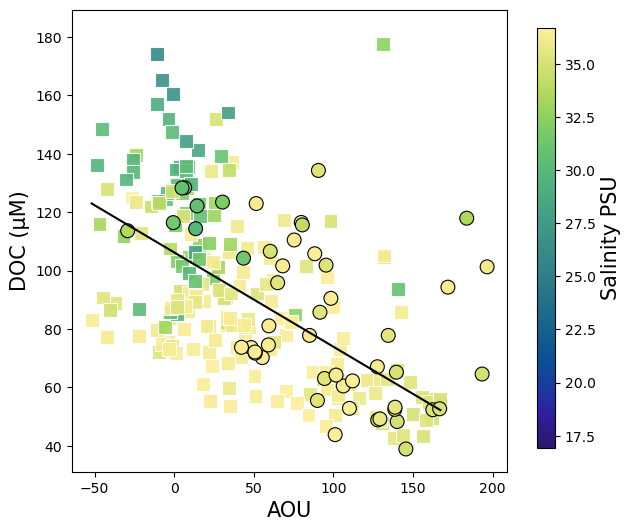

In [5]:
def xyplotcolor_2data(df, df2):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = data_wc_all[z_var].min()
    vmax = data_wc_all[z_var].max()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)
    
    sub2 = df2.dropna(subset=[x_var, y_var])
    data2 = sub2[[x_var, y_var, z_var]]
    colors2 = data2[z_var].astype(float)
    X2 = data2[[x_var]]
    y2 = data2[y_var]
    
    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color,marker ="s", s=100, alpha = .9, data=data, ax=axes, legend=False, vmin=vmin, vmax=vmax)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

    
    sns.scatterplot(x=x_var, y=y_var, c=colors2, cmap=z_var_color, s=100, data=data2, edgecolor = 'black', ax=axes, legend=False, vmin=vmin, vmax=vmax)

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)
    axes.set_ylim(data_wc_all[y_var].min()*.8, data_wc_all[y_var].max()*.7)

    #axes.set_title(titel + f'R\u00B2: {r*r:.2f}', size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()

    
x_var = 'aou'
y_var = 'NPOC_uM'

x_var_lab = 'AOU'
y_var_lab = 'DOC (µM)'

z_var = 'sal'
z_var_lab = 'Salinity PSU'
z_var_color = cmo.haline


titel = "BBL and Water Col "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_2data(data_wc, data_wc_bbl)


## part 1 ##

Define Conservite mixing and subtract river contripution 

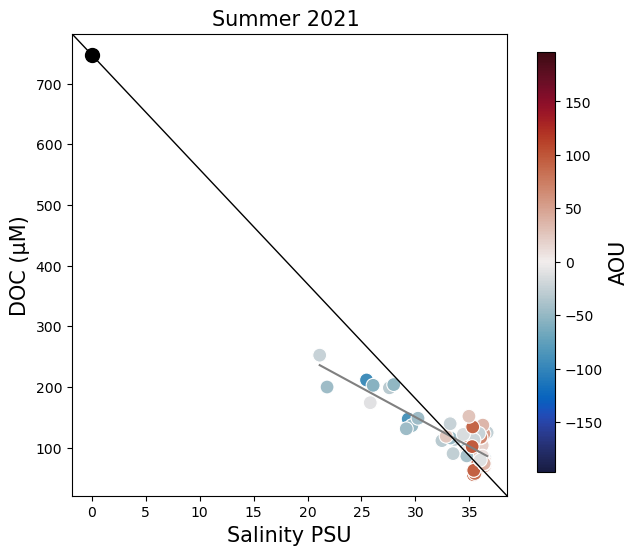

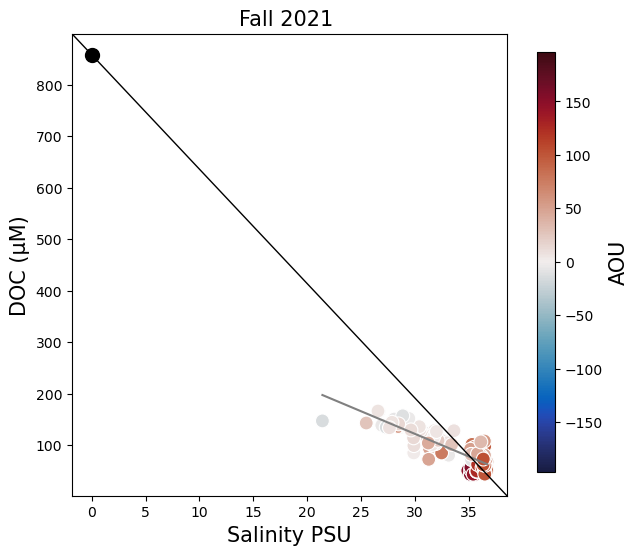

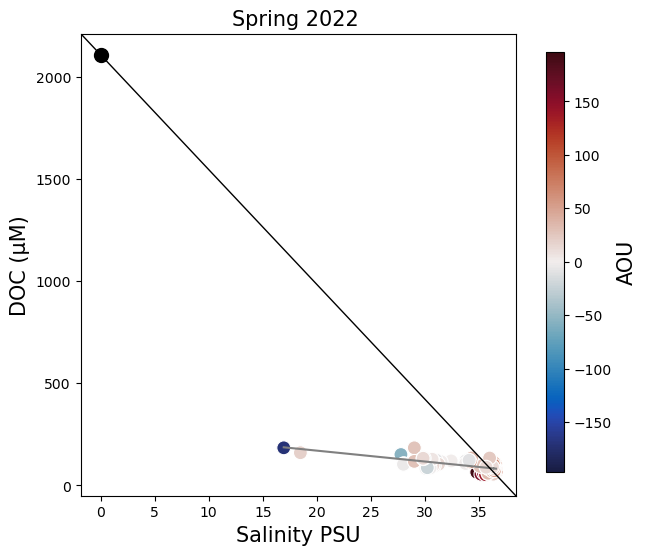

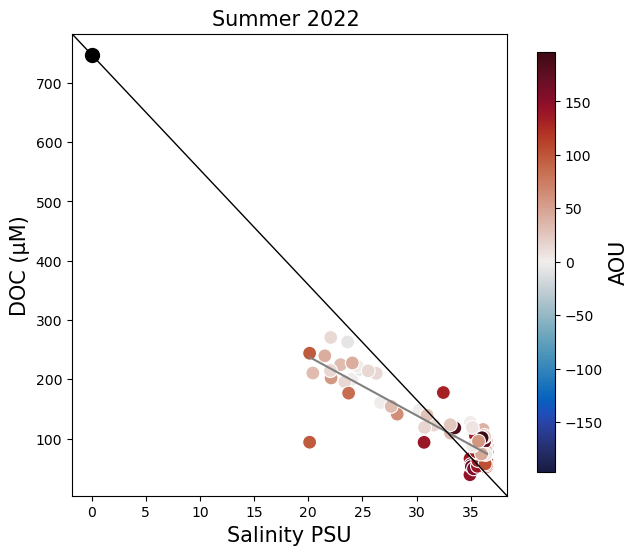

In [6]:
def xyplotcolor_line_ab(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = data_wc_all[z_var].max()*-1
    vmax = data_wc_all[z_var].max()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)

    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color, s=100, data=data, ax=axes, legend=False , vmin=vmin, vmax=vmax)
    axes.plot([0], [season_DOC*1000/12], marker='o', markersize=10, color="black")
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='grey')

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel, size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    axes.axline((0, season_DOC*1000/12), (data[x_var].max(), data[y_var].min()), linewidth=1, color='black')
    
    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()

y_var = 'NPOC_uM'
x_var = 'sal' 

x_var_lab = 'Salinity PSU'
y_var_lab = 'DOC (µM)' 

z_var = 'aou'
z_var_lab = 'AOU'
z_var_color = cmo.balance

titel = "Summer 2021 "
season_DOC = 8.97
save_name = 'sal_temp_doc_wc'
xyplotcolor_line_ab(data_wc_all[data_wc_all['Campaign'] == 'GOM2021'])

titel = "Fall 2021 "
season_DOC = 10.3
save_name = 'sal_temp_doc_wc'
xyplotcolor_line_ab(data_wc_all[data_wc_all['Campaign'] == 'GOM21FA'])

titel = "Spring 2022 "
season_DOC = 25.3
save_name = 'sal_temp_doc_wc'
xyplotcolor_line_ab(data_wc_all[data_wc_all['Campaign'] == 'GOM22SP'])

titel = "Summer 2022 "
season_DOC = 8.97
save_name = 'sal_temp_doc_wc'
xyplotcolor_line_ab(data_wc_all[data_wc_all['Campaign'] == 'GOM22SU'])

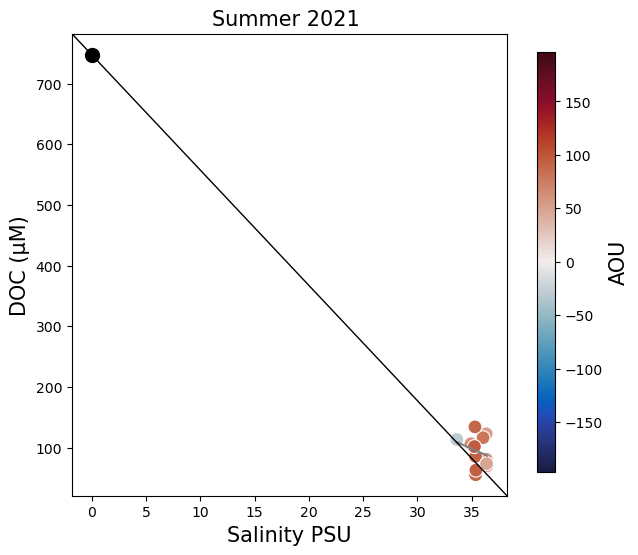

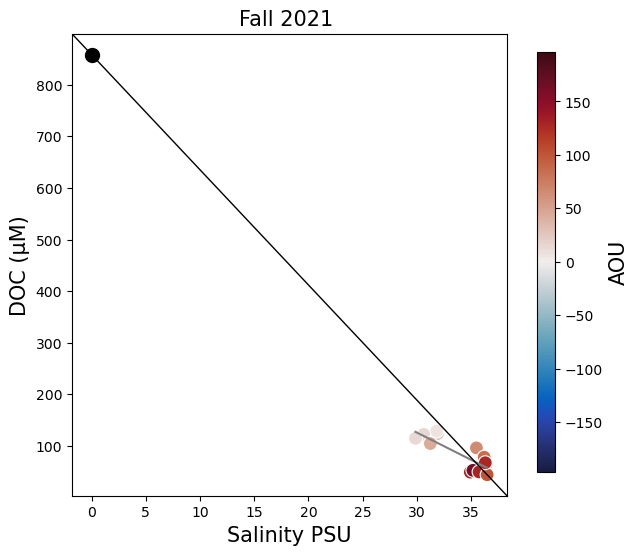

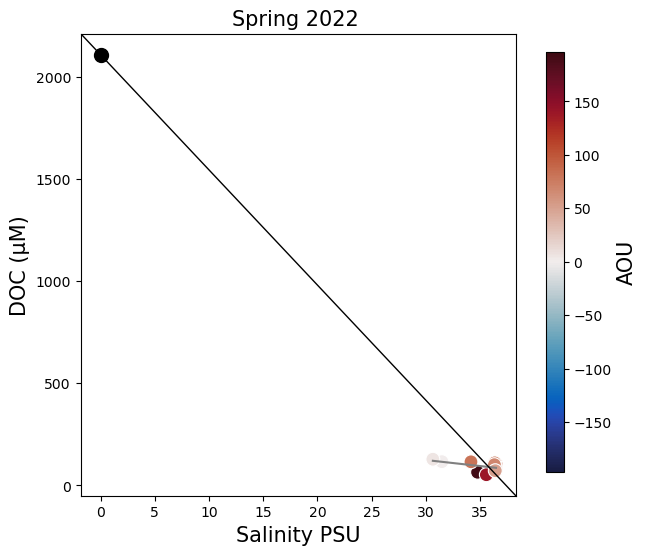

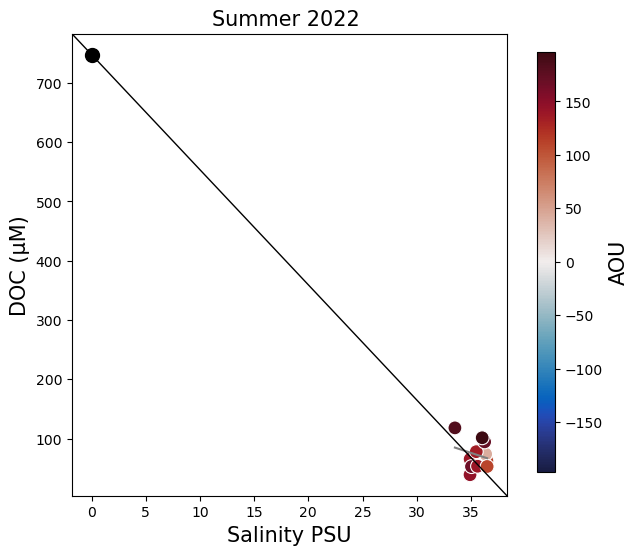

In [7]:
y_var = 'NPOC_uM'
x_var = 'sal' 

x_var_lab = 'Salinity PSU'
y_var_lab = 'DOC (µM)' 

z_var = 'aou'
z_var_lab = 'AOU'
z_var_color = cmo.balance

titel = "Summer 2021 "
season_DOC = 8.97
save_name = 'sal_temp_doc_wc'
xyplotcolor_line_ab(data_wc_bbl[data_wc_bbl['Campaign'] == 'GOM2021'])

titel = "Fall 2021 "
season_DOC = 10.3
save_name = 'sal_temp_doc_wc'
xyplotcolor_line_ab(data_wc_bbl[data_wc_bbl['Campaign'] == 'GOM21FA'])

titel = "Spring 2022 "
season_DOC = 25.3
save_name = 'sal_temp_doc_wc'
xyplotcolor_line_ab(data_wc_bbl[data_wc_bbl['Campaign'] == 'GOM22SP'])

titel = "Summer 2022 "
season_DOC = 8.97
save_name = 'sal_temp_doc_wc'
xyplotcolor_line_ab(data_wc_bbl[data_wc_bbl['Campaign'] == 'GOM22SU'])

salinity cuttoff: 40  PSU
not with surf data
not with river data





C:\Users\hmlbr\AppData\Local\Temp\ipykernel_3380\3815153089.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wc_bbl['DOC_uM_sal_corrected'] = data_wc_bbl.apply(calculate_doc, axis=1)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_3380\3815153089.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wc['DOC_uM_sal_corrected'] = data_wc.apply(calculate_doc, axis=1)


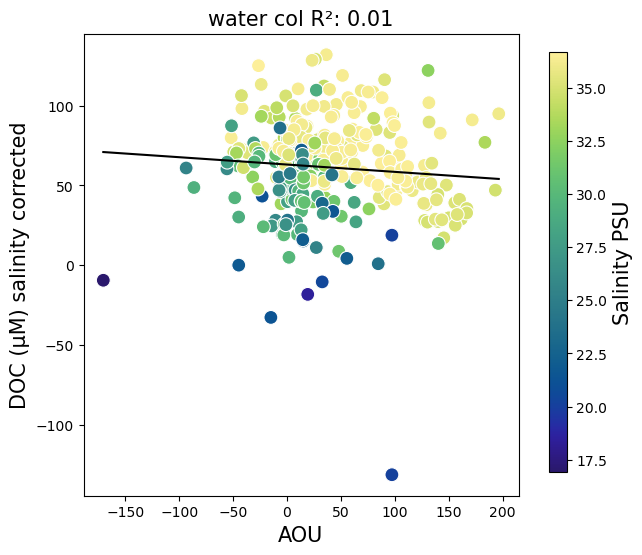

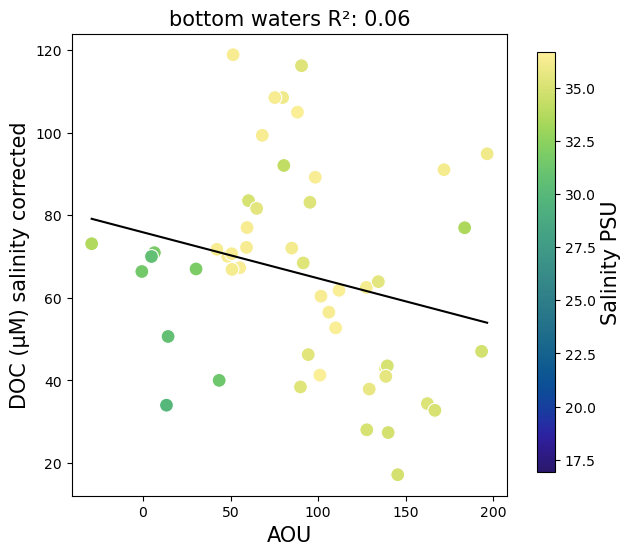

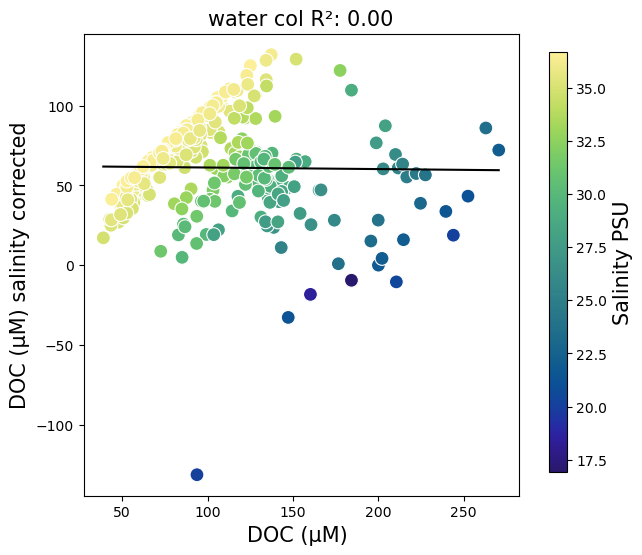

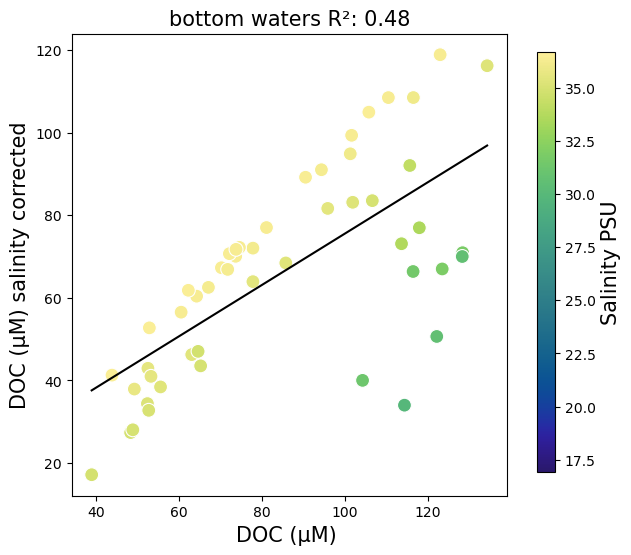

Summer 2021
Intercept (TLS): 573.7542243384459
Slope (TLS): -13.485066203817368
R2 (TLS): 0.3635734805017104

Fall 2021
Intercept (TLS): 487.5704032923828
Slope (TLS): -11.771585701617196
R2 (TLS): 0.6887650050861311

Spring 2022
Intercept (TLS): 432.8374775186373
Slope (TLS): -9.872402162813028
R2 (TLS): 0.3211210221493958

Summer 2022
Intercept (TLS): 569.0971241707718
Slope (TLS): -13.737145142137804
R2 (TLS): 0.46959275568750236



In [8]:
def tls_regression(x, y):
    # Add a column of ones to x to represent the intercept
    X = np.column_stack((np.ones(len(x)), x))

    # Compute the SVD of X
    U, s, Vt = np.linalg.svd(X, full_matrices=False)

    # Compute the pseudo-inverse of X
    X_inv = np.dot(Vt.T / s, U.T)

    # Compute the TLS regression coefficients
    beta_tls = np.dot(X_inv, y)

    return beta_tls

#decide a sal cutoff for the regression 
sal_cut_off = 40
print(f"salinity cuttoff: {sal_cut_off}  PSU")

#decide on river data added 
river_pt = 'no' 

#decide on surface water added 
surf_pts = 'no' 


# Get each season alone
GOM2021 = data_wc_all[data_wc_all['Campaign'] == 'GOM2021']
GOM21FA = data_wc_all[data_wc_all['Campaign'] == 'GOM21FA']
GOM22SP = data_wc_all[data_wc_all['Campaign'] == 'GOM22SP']
GOM22SU = data_wc_all[data_wc_all['Campaign'] == 'GOM22SU']

#use only data with low sal
GOM2021 = GOM2021[GOM2021['sal'] <= sal_cut_off]
GOM21FA = GOM21FA[GOM21FA['sal'] <= sal_cut_off]
GOM22SP = GOM22SP[GOM22SP['sal'] <= sal_cut_off]
GOM22SU = GOM22SU[GOM22SU['sal'] <= sal_cut_off]

if surf_pts == 'no': 
    GOM2021 = GOM2021[GOM2021['group'] != "Surface"]
    GOM21FA = GOM21FA[GOM21FA['group'] != "Surface"]
    GOM22SP = GOM22SP[GOM22SP['group'] != "Surface"]
    GOM22SU = GOM22SU[GOM22SU['group'] != "Surface"]
    print('not with surf data')
else: 
    print('with surf data')

DOC_sum21 = 8.97
DOC_fal21 = 10.3
DOC_spr22 = 25.3
DOC_sum22 = 8.97

# SUMMER 2021
x_var = GOM2021['sal']
y_var = GOM2021['NPOC_uM']

if river_pt == 'yes': 
    x_var.loc[len(x_var)] = 0
    y_var.loc[len(y_var)] = DOC_sum21*1000/12
    print('with river data')
else: 
    print('not with river data')

beta_tls = tls_regression(x_var, y_var)
intercept_tls, slope_tls = beta_tls

results_sum_21 = regress2(x_var, y_var, _method_type_2="reduced major axis")

slope_sum21 = results_sum_21['slope']
intercept_sum21 = results_sum_21['intercept']
r_sum21 = results_sum_21['r']

# FALL 2021
x_var = GOM21FA['sal']
y_var = GOM21FA['NPOC_uM']

if river_pt == 'yes': 
    x_var.loc[len(x_var)] = 0
    y_var.loc[len(y_var)] = DOC_fal21*1000/12
else: 
    print('')

beta_tls = tls_regression(x_var, y_var)
intercept_tls, slope_tls = beta_tls

results_fal_21 = regress2(x_var, y_var, _method_type_2="reduced major axis")

slope_fal21 = results_fal_21['slope']
intercept_fal21 = results_fal_21['intercept']
r_fal21 = results_fal_21['r']

# SPRING 2021
x_var = GOM22SP['sal']
y_var = GOM22SP['NPOC_uM']

if river_pt == 'yes': 
    x_var.loc[len(x_var)] = 0
    y_var.loc[len(y_var)] = DOC_spr22*1000/12
else: 
    print('')

beta_tls = tls_regression(x_var, y_var)
intercept_tls, slope_tls = beta_tls

results_spr_22 = regress2(x_var, y_var, _method_type_2="reduced major axis")

slope_spr22 = results_spr_22['slope']
intercept_spr22 = results_spr_22['intercept']
r_spr22 = results_spr_22['r']

# SUMMER 2022
x_var = GOM22SU['sal']
y_var = GOM22SU['NPOC_uM']

if river_pt == 'yes': 
    x_var.loc[len(x_var)] = 0
    y_var.loc[len(y_var)] = DOC_sum22*1000/12
else: 
    print('')

beta_tls = tls_regression(x_var, y_var)
intercept_tls, slope_tls = beta_tls

results_sum_22 = regress2(x_var, y_var, _method_type_2="reduced major axis")

slope_sum22 = results_sum_22['slope']
intercept_sum22 = results_sum_22['intercept']
r_sum22 = results_sum_22['r']

# Apply the calculation conditionally
def calculate_doc(row):
    if row['Campaign'] == 'GOM2021' and row['sal'] <= sal_cut_off:
        return row['NPOC_uM'] + (slope_sum21 * (GOM2021['sal'].max() - row['sal']))
    elif row['Campaign'] == 'GOM21FA' and row['sal'] <= sal_cut_off:
        return row['NPOC_uM'] + (slope_fal21 * (GOM21FA['sal'].max() - row['sal']))
    elif row['Campaign'] == 'GOM22SP' and row['sal'] <= sal_cut_off:
        return row['NPOC_uM'] + (slope_spr22 * (GOM22SP['sal'].max() - row['sal']))
    elif row['Campaign'] == 'GOM22SU'and row['sal'] <= sal_cut_off:
        return row['NPOC_uM'] + (slope_sum22 * (GOM22SU['sal'].max() - row['sal']))
    else:
        return row['NPOC_uM']

# Apply the function to calculate 'DOC_uM_sal_corrected'
data_wc_all['DOC_uM_sal_corrected'] = data_wc_all.apply(calculate_doc, axis=1)
data_wc_bbl['DOC_uM_sal_corrected'] = data_wc_bbl.apply(calculate_doc, axis=1)
data_wc['DOC_uM_sal_corrected'] = data_wc.apply(calculate_doc, axis=1)

x_var = 'aou'
y_var = 'DOC_uM_sal_corrected'

x_var_lab = 'AOU'
y_var_lab = 'DOC (µM) salinity corrected'

z_var = 'sal'
z_var_lab = 'Salinity PSU'
z_var_color = cmo.haline

titel = "water col "
save_name = 'DOC_corrected_for_salinity'
xyplotcolor(data_wc_all)

titel = "bottom waters "
save_name = 'DOC_corrected_for_salinity'
xyplotcolor(data_wc_bbl)

x_var = 'NPOC_uM'
y_var = 'DOC_uM_sal_corrected'

x_var_lab = 'DOC (µM) '
y_var_lab = 'DOC (µM) salinity corrected'

z_var = 'sal'
z_var_lab = 'Salinity PSU'
z_var_color = cmo.haline

titel = "water col "
save_name = 'DOC_corrected_for_salinity'
xyplotcolor(data_wc_all)

titel = "bottom waters "
save_name = 'DOC_corrected_for_salinity'
xyplotcolor(data_wc_bbl)

print('Summer 2021')
print("Intercept (TLS):", results_sum_21['intercept'])
print("Slope (TLS):", results_sum_21['slope'])
print("R2 (TLS):", results_sum_21['r']*results_sum_21['r'])
print("")
print('Fall 2021')
print("Intercept (TLS):", results_fal_21['intercept'])
print("Slope (TLS):", results_fal_21['slope'])
print("R2 (TLS):", results_fal_21['r']*results_fal_21['r'])
print("")
print('Spring 2022')
print("Intercept (TLS):", results_spr_22['intercept'])
print("Slope (TLS):", results_spr_22['slope'])
print("R2 (TLS):", results_spr_22['r']*results_spr_22['r'])
print("")
print('Summer 2022')
print("Intercept (TLS):", results_sum_22['intercept'])
print("Slope (TLS):", results_sum_22['slope'])
print("R2 (TLS):", results_sum_22['r']*results_sum_22['r'])
print("")

## part 2 ##

LooK at DOC to AOU relationship in the water col to determin DOC consumption 

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_3380\393126668.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wc_bbl['aou_ceq_doc'] = data_wc_bbl['aou_ceq'] * ((Cal_slope*-1) )
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_3380\393126668.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wc_bbl['aou_ceq_doc_diff'] = data_wc_bbl['DOC_uM_sal_corrected'] -  data_wc_bbl['aou_ceq_doc']
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_3380\393126668.py:49: SettingWithCopyWarning: 
A value is trying to be s

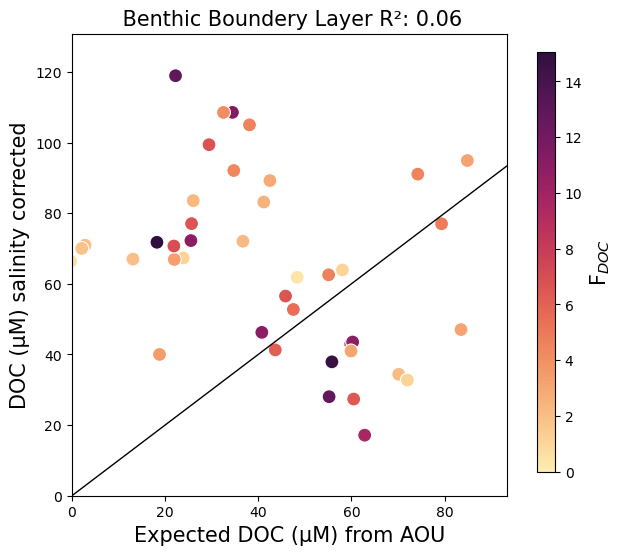

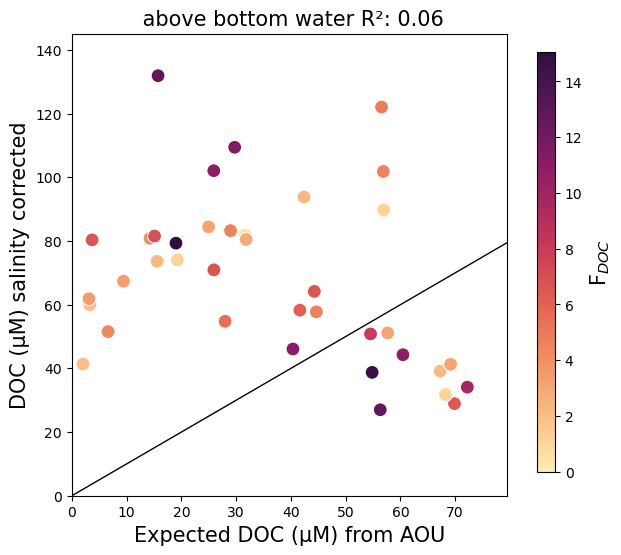

In [9]:
def xyplotcolor_flux_pred(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = 0
    vmax = data[z_var].max()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)

    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color, s=100, data=data, ax=axes, legend=False, vmin=vmin, vmax=vmax)
    #sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel + f'R\u00B2: {score:.2f}', size = 15)

    axes.set_xlim(0, data[x_var].max()*1.1)
    axes.set_ylim(0, data[y_var].max()*1.1)
    
    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    axes.axline(( 0,0), (150,150), linewidth=1, color='black')

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()


#calcuate the DOC expected given AOU with the salinity corrected data 
data_wc_bbl['aou_ceq_doc'] = data_wc_bbl['aou_ceq'] * ((Cal_slope*-1) )
data_wc_bbl['aou_ceq_doc_diff'] = data_wc_bbl['DOC_uM_sal_corrected'] -  data_wc_bbl['aou_ceq_doc'] 

#calcuate the DOC expected given AOU with the salinity corrected data 
data_wc_all['aou_ceq_doc'] = data_wc_all['aou_ceq'] * ((Cal_slope*-1) )
data_wc_all['aou_ceq_doc_diff'] = data_wc_all['DOC_uM_sal_corrected'] -  data_wc_all['aou_ceq_doc'] 

#calcuate the DOC expected given AOU with the salinity corrected data 
data_wc['aou_ceq_doc'] = data_wc['aou_ceq'] * ((Cal_slope*-1) )
data_wc['aou_ceq_doc_diff'] = data_wc['DOC_uM_sal_corrected'] -  data_wc['aou_ceq_doc'] 

data_wc_deep = data_wc
data_wc_deep.index = data_wc_deep['percent_doc_resp']
idx_max = data_wc_deep.groupby('code.1')['Depth'].idxmax()
data_wc_deep = data_wc_deep.loc[idx_max]
data_wc_deep.index = data_wc_deep['code']

x_var = 'aou_ceq_doc'
y_var = 'DOC_uM_sal_corrected'

x_var_lab = 'Expected DOC (µM) from AOU'
y_var_lab = 'DOC (µM) salinity corrected'

z_var = 'pw_flux_doc'
z_var_lab = 'F$_{DOC}$'
z_var_color = cmo.matter

titel = " Benthic Boundery Layer "
save_name = 'aou_all_sal_bbl_doc'
xyplotcolor_flux_pred(data_wc_bbl)

titel = " above bottom water "
save_name = 'aou_all_sal_bbl_doc'
xyplotcolor_flux_pred(data_wc_deep)





Intercept (TLS): 27.33935251491343
Slope (TLS): -0.6565586592075021


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


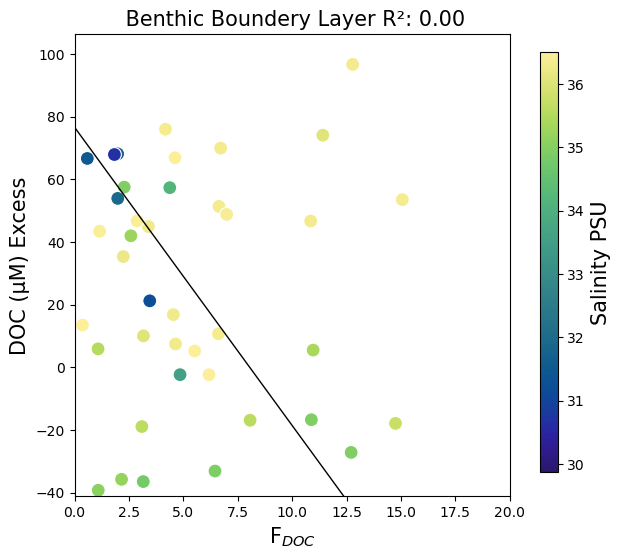

Intercept (TLS): 40.229300023611266
Slope (TLS): -1.0518449587810605


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


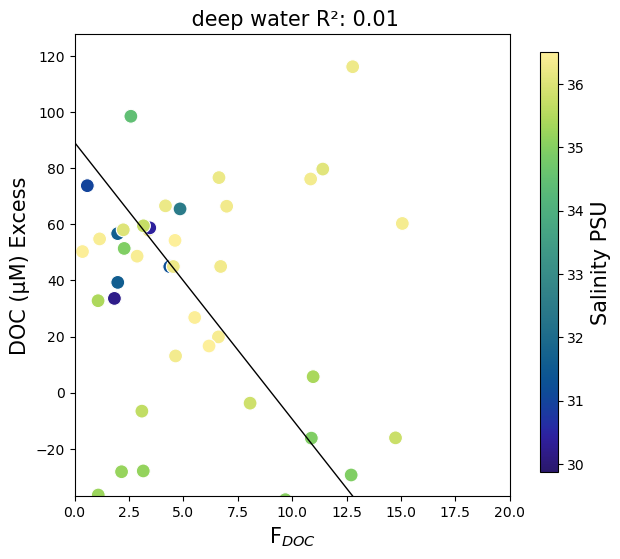

In [10]:
def xyplotcolor_flux_pred(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = data_wc_bbl[z_var].min()
    vmax = data_wc_bbl[z_var].max()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)

    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color, s=100, data=data, ax=axes, legend=False, vmin=vmin, vmax=vmax)
    #sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')
    
    # Perform TLS regression
    beta_tls = tls_regression(X, y)

    # Print coefficients
    intercept_tls, slope_tls = beta_tls
    print("Intercept (TLS):", intercept_tls)
    print("Slope (TLS):", slope_tls)

    results = regress2(X, y, _method_type_2="reduced major axis")

    intercept = results['intercept']
    slope = results['slope']
    r= results['r']

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_xlim(0, 20)
    axes.set_ylim(data[y_var].min()*.9, data[y_var].max()*1.1)

    axes.axline((0,0+intercept), (130,(130*slope)+intercept), linewidth=1, color='black')
    axes.set_title(titel + f'R\u00B2: {r*r:.2f}', size = 15)
    
    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()



y_var = 'aou_ceq_doc_diff'
z_var = 'sal'

y_var_lab = r'DOC (µM) Excess'
z_var_lab = 'Salinity PSU'

x_var = 'pw_flux_doc'
x_var_lab = 'F$_{DOC}$'
z_var_color = cmo.haline

titel = " Benthic Boundery Layer "
save_name = 'aou_all_sal_bbl_doc'
xyplotcolor_flux_pred(data_wc_bbl)

titel = " deep water "
save_name = 'aou_all_sal_bbl_doc'
xyplotcolor_flux_pred(data_wc_deep)



Intercept (TLS): -16.183263529595948
Slope (TLS): -0.3616892175456079


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


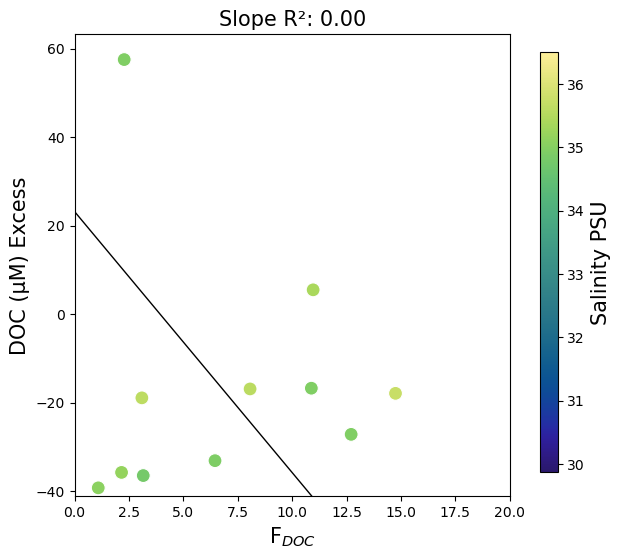

Intercept (TLS): 17.059466373919236
Slope (TLS): 3.7330280177439983


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


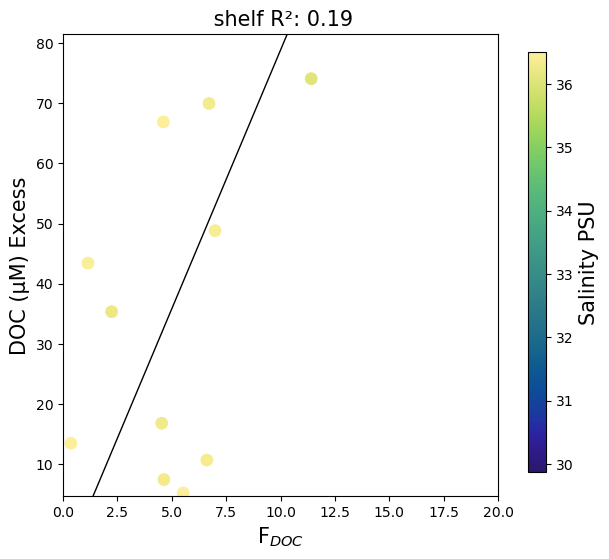

Intercept (TLS): 37.206279713452176
Slope (TLS): 1.870715724974671


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


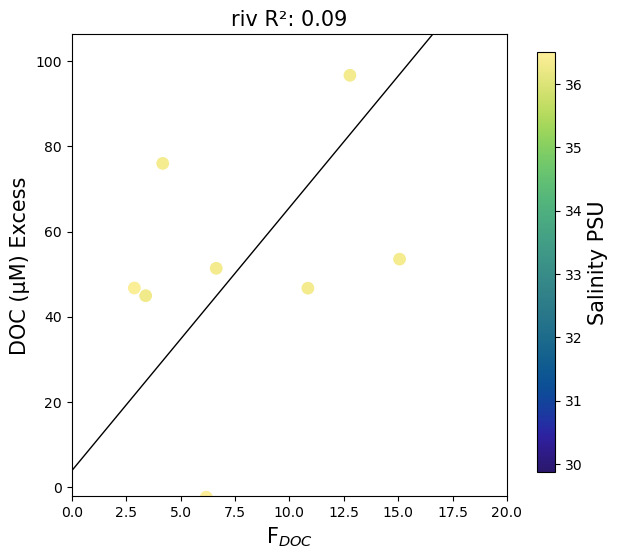

Intercept (TLS): 61.43299480921219
Slope (TLS): -8.646723839649114


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


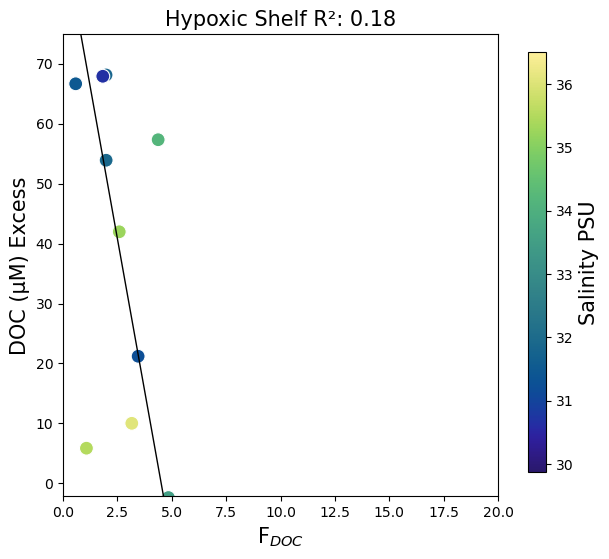

In [11]:

titel = "Slope "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_flux_pred( data_wc_bbl[data_wc_bbl['rgn'] == "Slope"])

titel = " shelf "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_flux_pred(data_wc_bbl[data_wc_bbl['rgn'] == "Distal Shelf"])

titel = "riv "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_flux_pred(data_wc_bbl[data_wc_bbl['rgn'] == "Proximal Shelf"])


titel = "Hypoxic Shelf "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_flux_pred(data_wc_bbl[data_wc_bbl['rgn'] == "Hypoxic Shelf"])

Intercept (TLS): 27.33935251491343
Slope (TLS): -0.6565586592075021


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


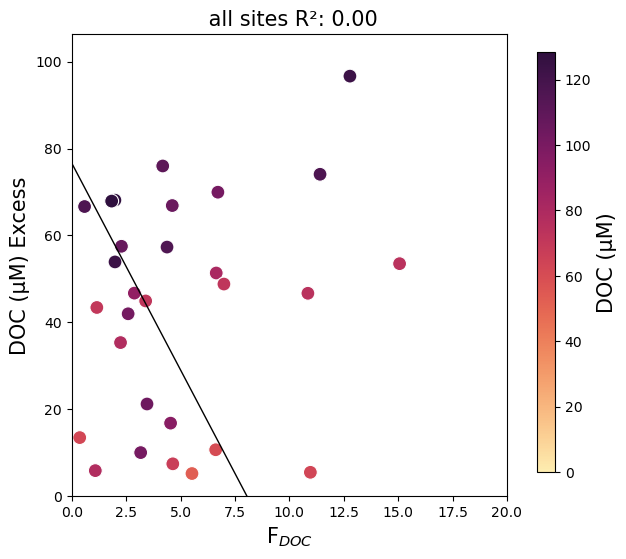

Intercept (TLS): 16.301161178128666
Slope (TLS): 0.4889807960301116


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


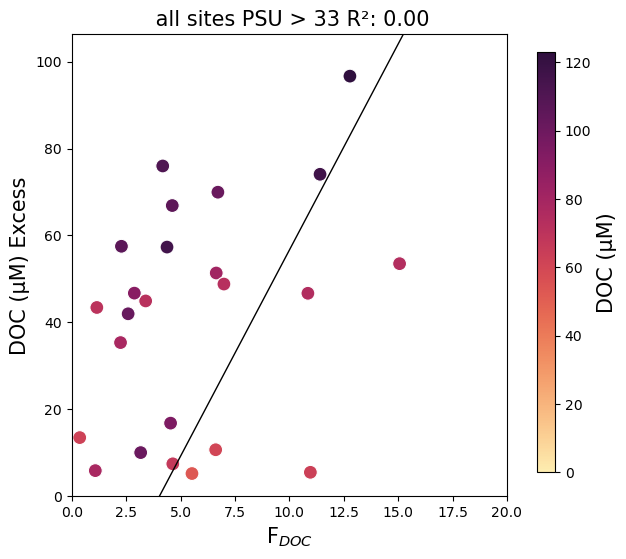

Intercept (TLS): 31.264991230470642
Slope (TLS): 2.031385682963773


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


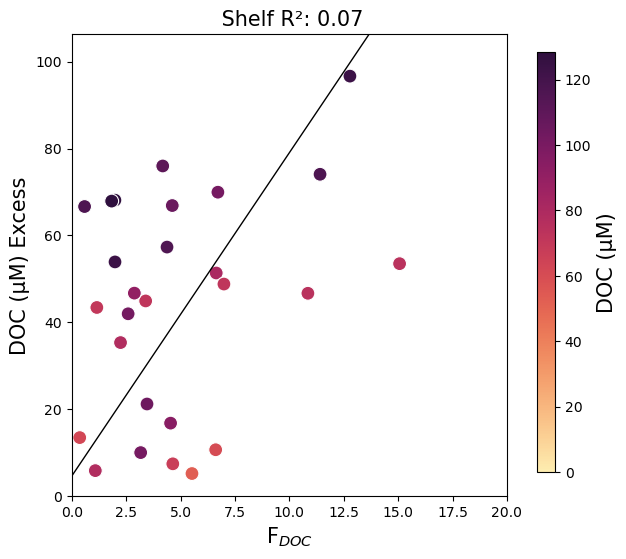

Intercept (TLS): 19.48537812730055
Slope (TLS): 3.3958205129074237


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


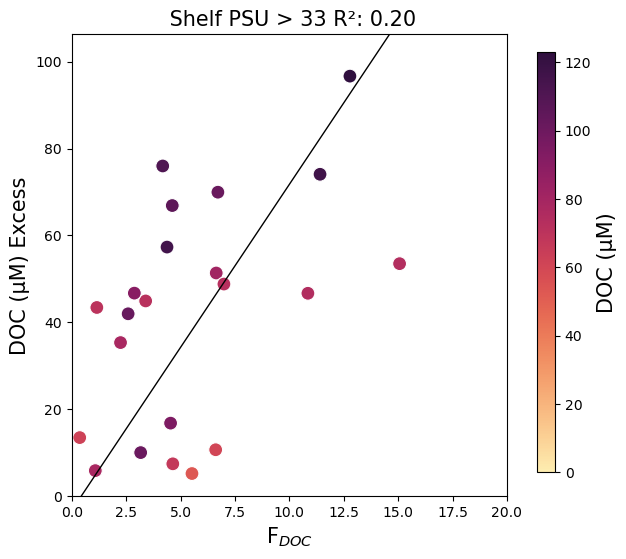

In [12]:
def xyplotcolor_flux_pred(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = 0
    vmax = data[z_var].max()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)

    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color, s=100, data=data, ax=axes, legend=False, vmin=vmin, vmax=vmax)
    #sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')
    
    # Perform TLS regression
    beta_tls = tls_regression(X, y)

    # Print coefficients
    intercept_tls, slope_tls = beta_tls
    print("Intercept (TLS):", intercept_tls)
    print("Slope (TLS):", slope_tls)

    results = regress2(X, y, _method_type_2="reduced major axis")

    intercept = results['intercept']
    slope = results['slope']
    r= results['r']

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_xlim(0, 20)
    axes.set_ylim(0, data[y_var].max()*1.1)

    axes.axline((0,0+intercept), (130,(130*slope)+intercept), linewidth=1, color='black')
    axes.set_title(titel + f'R\u00B2: {r*r:.2f}', size = 15)
    
    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()

y_var = 'aou_ceq_doc_diff'
z_var = 'NPOC_uM'

y_var_lab = r'DOC (µM) Excess'
z_var_lab = r'DOC (µM)'

x_var = 'pw_flux_doc'
x_var_lab = 'F$_{DOC}$'
z_var_color = cmo.matter

titel = " all sites "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_flux_pred(data_wc_bbl)

titel = " all sites PSU > 33 "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_flux_pred(data_wc_bbl[data_wc_bbl['sal'] >= 33])

titel = " Shelf "
save_name = 'aou_sal_wc_and_bbl'
data_bbl_shelf = data_wc_bbl[data_wc_bbl['rgn'] != "Slope"]
xyplotcolor_flux_pred(data_bbl_shelf)

titel = " Shelf PSU > 33 "
save_name = 'aou_sal_wc_and_bbl'
data_bbl_shelf = data_wc_bbl[data_wc_bbl['rgn'] != "Slope"]
xyplotcolor_flux_pred(data_bbl_shelf[data_bbl_shelf['sal'] >= 33])

Intercept (TLS): 40.229300023611266
Slope (TLS): -1.0518449587810605


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


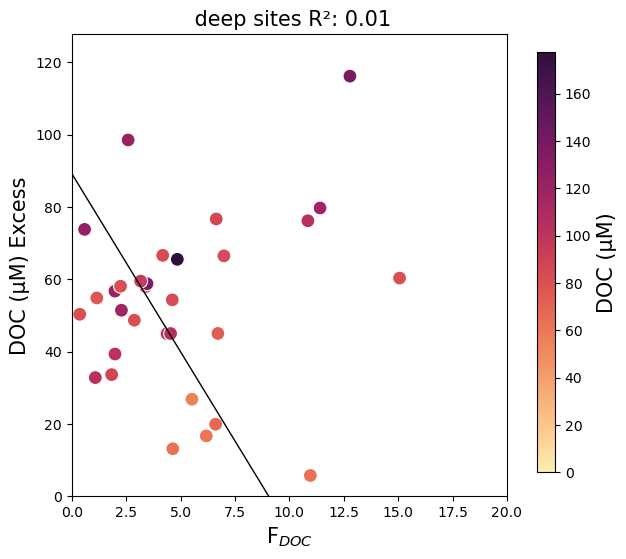

In [13]:
y_var = 'aou_ceq_doc_diff'
z_var = 'NPOC_uM'

y_var_lab = r'DOC (µM) Excess'
z_var_lab = r'DOC (µM)'

x_var = 'pw_flux_doc'
x_var_lab = 'F$_{DOC}$'
z_var_color = cmo.matter

titel = " deep sites "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_flux_pred(data_wc_deep)

Intercept (TLS): 27.33935251491343
Slope (TLS): -0.6565586592075021


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


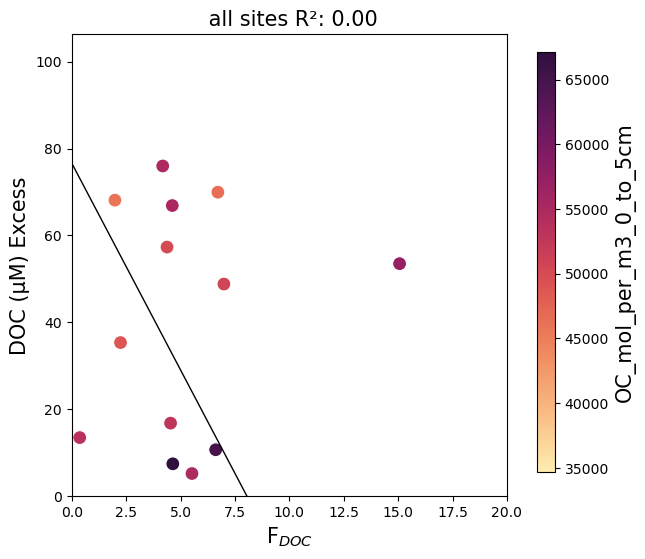

Intercept (TLS): 16.301161178128666
Slope (TLS): 0.4889807960301116


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


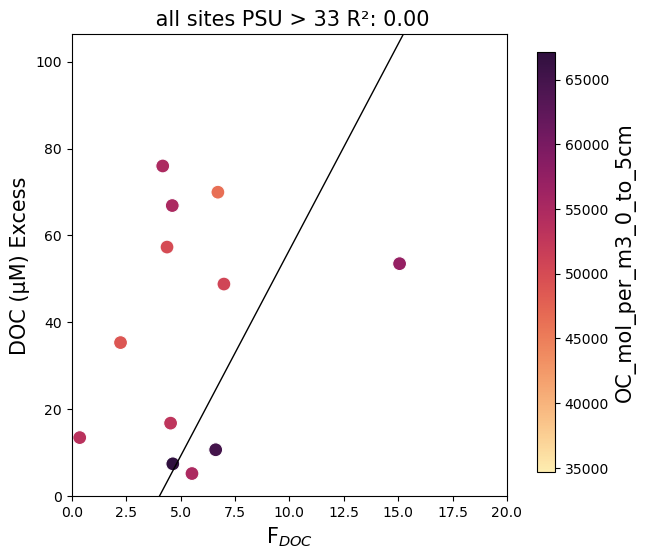

Intercept (TLS): 31.264991230470642
Slope (TLS): 2.031385682963773


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


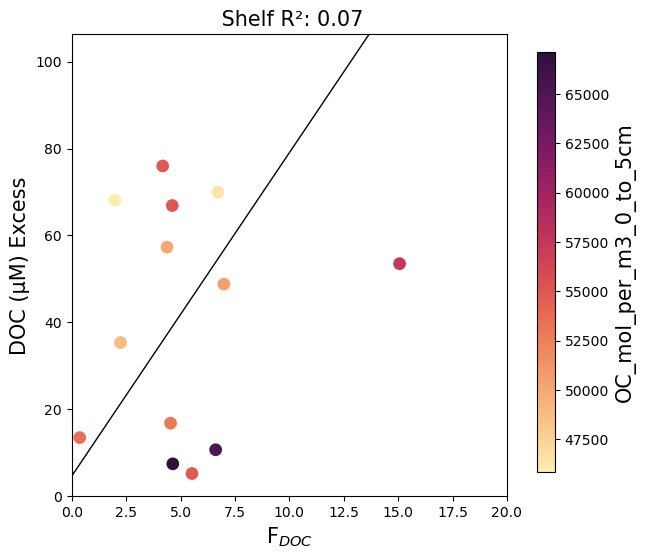

Intercept (TLS): 19.48537812730055
Slope (TLS): 3.3958205129074237


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


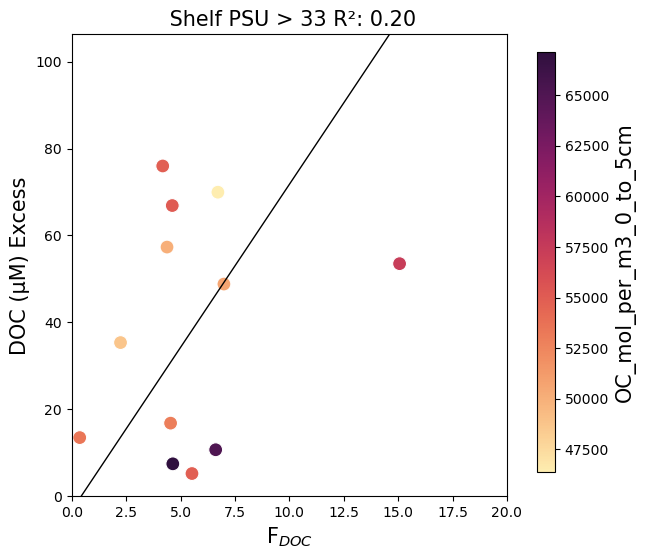

In [14]:
def xyplotcolor_flux_pred(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = data[z_var].min()
    vmax = data[z_var].max()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)

    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color, s=100, data=data, ax=axes, legend=False, vmin=vmin, vmax=vmax)
    #sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')
    
    # Perform TLS regression
    beta_tls = tls_regression(X, y)

    # Print coefficients
    intercept_tls, slope_tls = beta_tls
    print("Intercept (TLS):", intercept_tls)
    print("Slope (TLS):", slope_tls)

    results = regress2(X, y, _method_type_2="reduced major axis")

    intercept = results['intercept']
    slope = results['slope']
    r= results['r']

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_xlim(0, 20)
    axes.set_ylim(0, data[y_var].max()*1.1)

    axes.axline((0,0+intercept), (130,(130*slope)+intercept), linewidth=1, color='black')
    axes.set_title(titel + f'R\u00B2: {r*r:.2f}', size = 15)
    
    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()
    
y_var = 'aou_ceq_doc_diff'
y_var_lab = r'DOC (µM) Excess'

x_var = 'pw_flux_doc'
x_var_lab = 'F$_{DOC}$'

z_var = 'OC_mol_per_m3_0_to_5cm'
z_var_lab = r'OC_mol_per_m3_0_to_5cm'
z_var_color = cmo.matter

titel = " all sites "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_flux_pred(data_wc_bbl)

titel = " all sites PSU > 33 "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_flux_pred(data_wc_bbl[data_wc_bbl['sal'] >= 33])

titel = " Shelf "
save_name = 'aou_sal_wc_and_bbl'
data_bbl_shelf = data_wc_bbl[data_wc_bbl['rgn'] != "Slope"]
xyplotcolor_flux_pred(data_bbl_shelf)

titel = " Shelf PSU > 33 "
save_name = 'aou_sal_wc_and_bbl'
data_bbl_shelf = data_wc_bbl[data_wc_bbl['rgn'] != "Slope"]
xyplotcolor_flux_pred(data_bbl_shelf[data_bbl_shelf['sal'] >= 33])

Intercept (TLS): 40.229300023611266
Slope (TLS): -1.0518449587810605


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


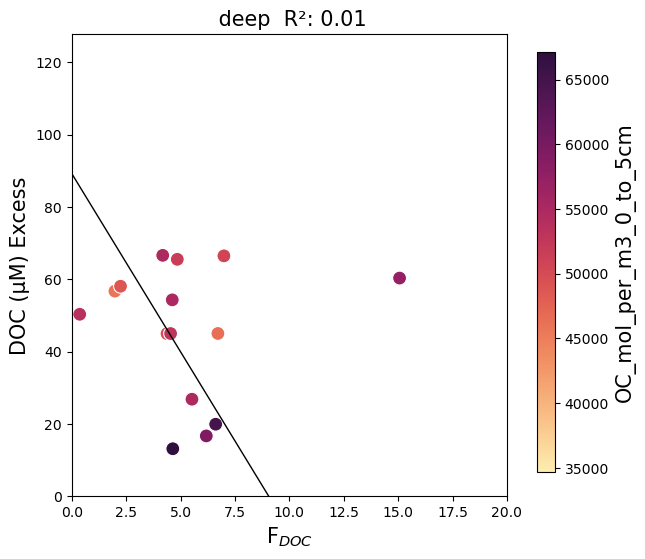

Intercept (TLS): 33.07176396746039
Slope (TLS): -0.418274915476957


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


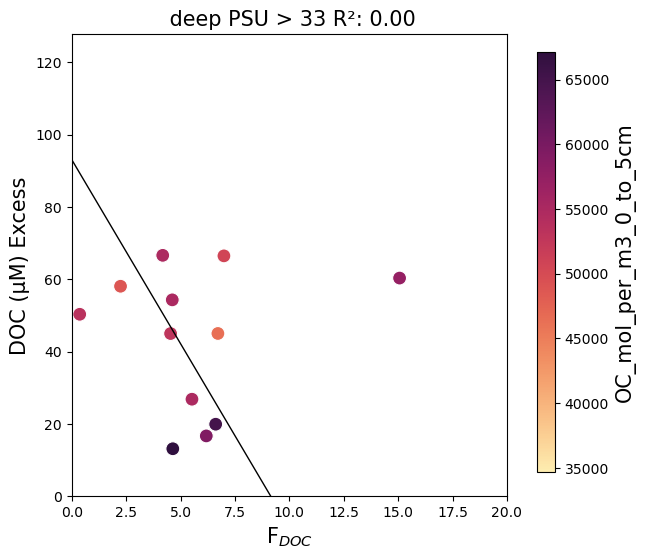

In [15]:

titel = " deep  "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_flux_pred(data_wc_deep)

titel = " deep PSU > 33 "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_flux_pred(data_wc_deep[data_wc_deep['sal'] >= 33])


Intercept (TLS): 27.33935251491343
Slope (TLS): -0.6565586592075021


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


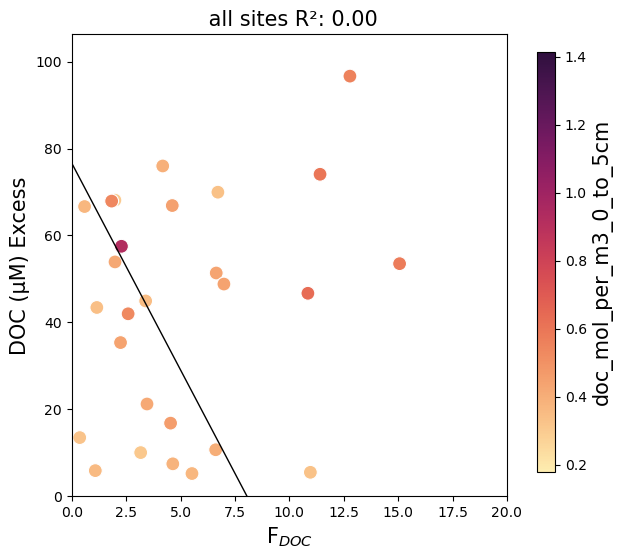

Intercept (TLS): 19.48537812730055
Slope (TLS): 3.3958205129074237


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


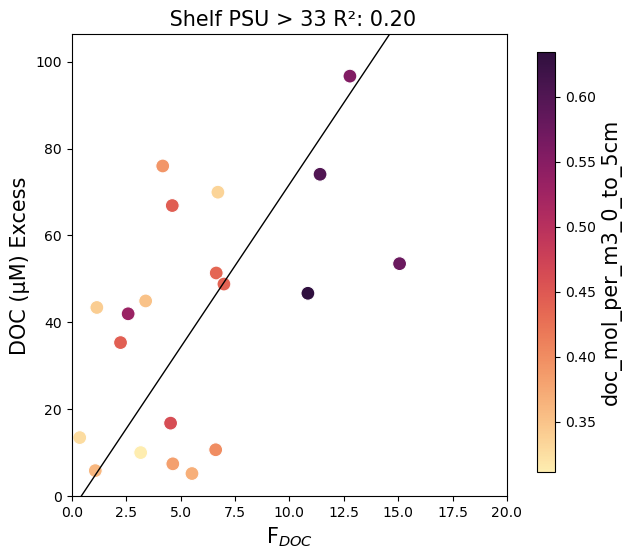

In [16]:

y_var = 'aou_ceq_doc_diff'
y_var_lab = r'DOC (µM) Excess'

x_var = 'pw_flux_doc'
x_var_lab = 'F$_{DOC}$'

z_var = 'doc_mol_per_m3_0_to_5cm'
z_var_lab = r'doc_mol_per_m3_0_to_5cm'
z_var_color = cmo.matter

titel = " all sites "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_flux_pred(data_wc_bbl)

titel = " Shelf PSU > 33 "
save_name = 'aou_sal_wc_and_bbl'
data_bbl_shelf = data_wc_bbl[data_wc_bbl['rgn'] != "Slope"]
xyplotcolor_flux_pred(data_bbl_shelf[data_bbl_shelf['sal'] >= 33])

Intercept (TLS): 27.33935251491343
Slope (TLS): -0.6565586592075021


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


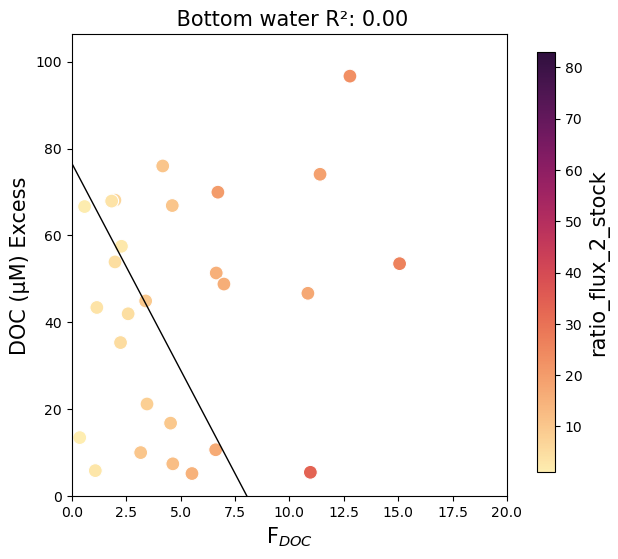

Intercept (TLS): 19.48537812730055
Slope (TLS): 3.3958205129074237


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


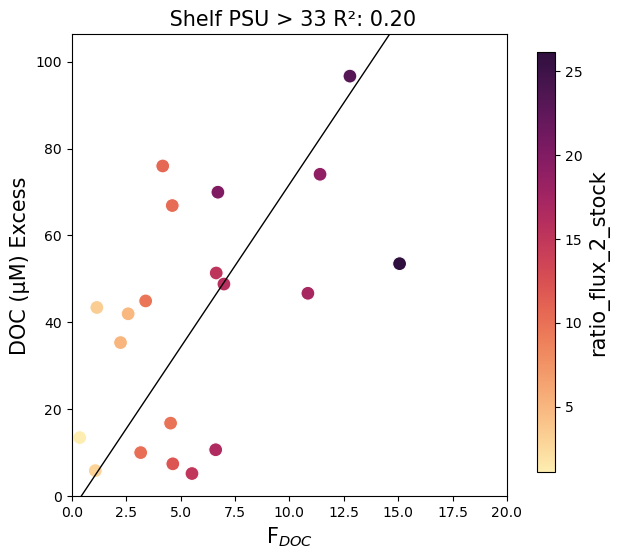

In [20]:

y_var = 'aou_ceq_doc_diff'
y_var_lab = r'DOC (µM) Excess'

x_var = 'pw_flux_doc'
x_var_lab = 'F$_{DOC}$'

z_var = 'ratio_flux_2_stock'
z_var_lab = r'ratio_flux_2_stock'

titel = " Bottom water "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_flux_pred(data_wc_bbl)

titel = " Shelf PSU > 33 "
save_name = 'aou_sal_wc_and_bbl'
data_bbl_shelf = data_wc_bbl[data_wc_bbl['rgn'] != "Slope"]
xyplotcolor_flux_pred(data_bbl_shelf[data_bbl_shelf['sal'] >= 33])

C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Intercept (TLS): -38.17797317572398
Slope (TLS): 9.48342217597239
R2 (TLS): 0.0026586026740861254


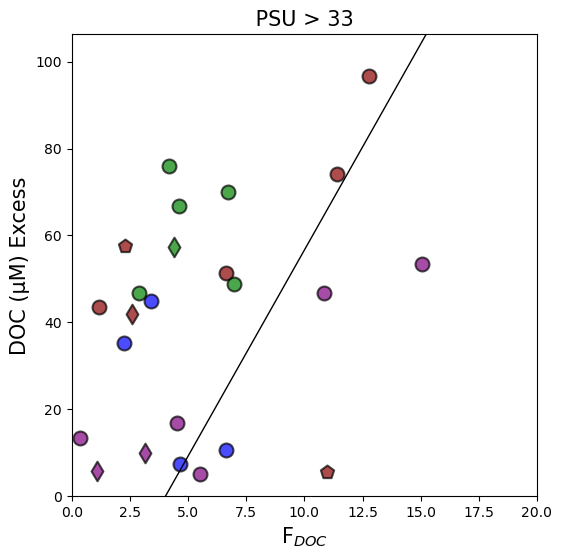

C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Intercept (TLS): 76.5831001569048
Slope (TLS): -9.516668534837615
R2 (TLS): 0.004759673701949479


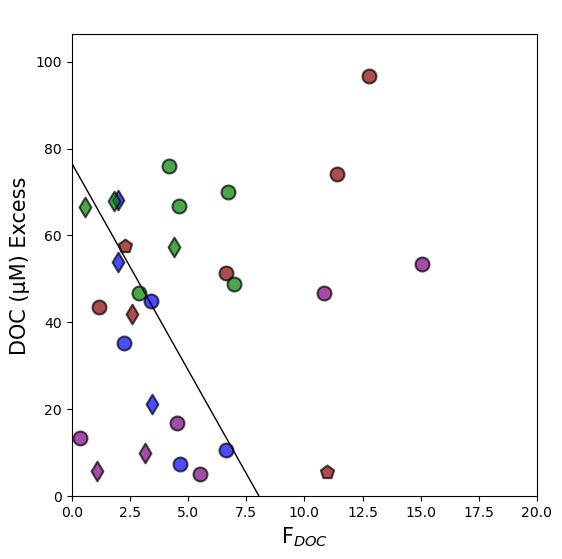

In [18]:
color_map = {
    'GOM2021': 'darkred',
    'GOM21FA': 'blue',
    'GOM22SP': 'green',
    'GOM22SU': 'purple'
}


marker_map = {
    'Slope': 'p',
    'Shelf': 'o',
    'River Delta': 's',
    'Hypoxic Shelf': 'd'
}

label_map = {
    'GOM2021': 'Summer 2021',
    'GOM21FA': 'Fall 2021',
    'GOM22SP': 'Spring 2022',
    'GOM22SU': 'Summer 2022'
}

def xyplotcolor_cat_color(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var, 'rgn']]
    subcat = data['Campaign'].tolist()
    subrgn = data['rgn'].tolist()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)
    
    for campaign in data[z_var].unique():
        for region in data['rgn'].unique():
            subset = data[(data[z_var] == campaign) & (data['rgn'] == region)]
            sns.scatterplot(
                x=subset[x_var], 
                y=subset[y_var], 
                marker=marker_map.get(region, 'o'), 
                color=color_map.get(campaign, 'grey'), 
                label=f"{label_map.get(campaign, campaign)} ({region})",
                s=100, 
                edgecolor='black', 
                linewidth=1.5, alpha = 0.7, 
                ax=axes, 
                legend=False
            )
    
    axes.set_xlabel(x_var_lab, size=15)
    axes.set_ylabel(y_var_lab, size=15)

    # Perform TLS regression
    beta_tls = tls_regression(X, y)

    # Print coefficients
    intercept_tls, slope_tls = beta_tls

    results = regress2(X, y, _method_type_2="reduced major axis")

    intercept = results['intercept']
    slope = results['slope']
    r = results['r'] * results['r']
    
    print("Intercept (TLS):", intercept)
    print("Slope (TLS):", slope)
    print("R2 (TLS):", r)
    
    axes.axline((0,0+intercept), (1,(1*slope)+intercept), linewidth=1, color='black')
    
    axes.set_xlim(0, 20)
    axes.set_ylim(0, data[y_var].max()*1.1)

    axes.set_title(titel, size=15)
    
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()

    
y_var = 'aou_ceq_doc_diff'
y_var_lab = r'DOC (µM) Excess'

x_var = 'pw_flux_doc'
x_var_lab = 'F$_{DOC}$'

z_var = 'Campaign'
#z_var_lab = 'Campaign'
#z_var_color = cmo.thermal

#titel = "Water Column "
#save_name = 'sal_temp_doc_wc'
#xyplotcolor_cat_color(data_wc)

titel = " PSU > 33 "
save_name = 'final_fig_maybe'
xyplotcolor_cat_color(data_wc_bbl[data_wc_bbl['sal'] >= 33])


titel = "  "
save_name = 'final_fig_maybe'
xyplotcolor_cat_color(data_wc_bbl)


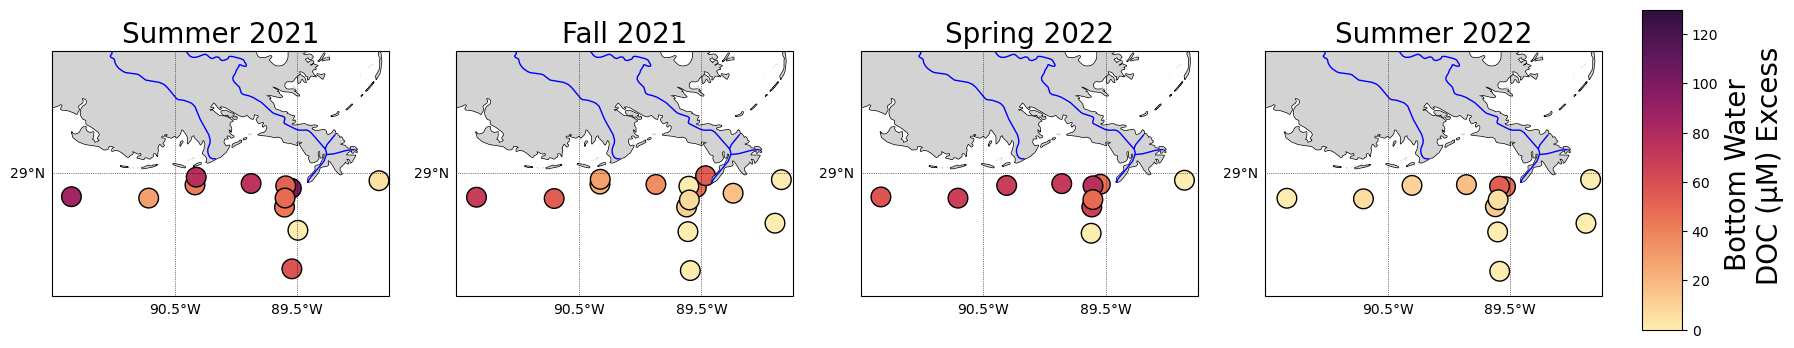

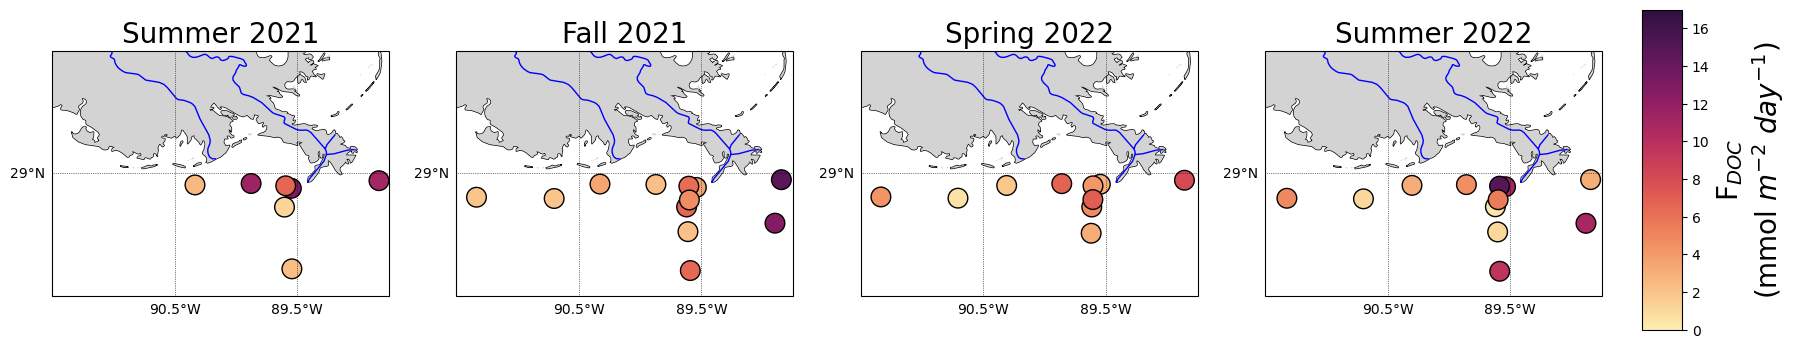

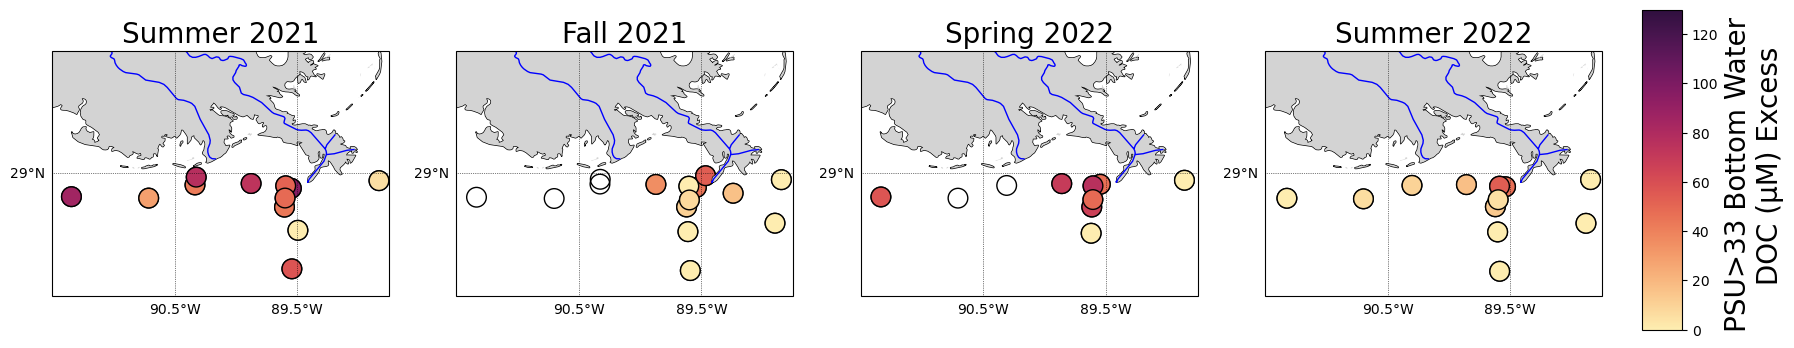

In [24]:
df_ow = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)
df_ow = df_ow[df_ow['Type'] == 'PW']
df_ow = df_ow[df_ow['Depth'] == 0]
df_ow['code'] = df_ow['Location'] + '_' + df_ow['Campaign']

df_ow.index = df_ow['code']

df_ow = df_ow.drop('St.9_GOM2021', axis=0)
df_ow = df_ow.drop('St.5B_GOM2021', axis=0)
df_ow = df_ow.drop('St.4_GOM2021', axis=0)
df_ow = df_ow.drop('St.14_GOM2021', axis=0)


df_ow['NPOC_ow'] = df_ow['NPOC_uM']

df_ow = df_ow['NPOC_ow']

df = pd.read_csv('../Dissertation_projects/Data/Stats_data_sets/bottom_water_DOC.csv', sep=',', index_col=0)

df['NPOC_ow'] = df_ow

df['aou-ceq_doc_diff'] = data_wc_bbl['aou_ceq_doc_diff']
df['pw_flux_doc'] = data_wc_bbl['pw_flux_doc']


lat_top=30
lat_bot=28
lon_left=-91.5
lon_rigth=-88.75
extent=[lon_left, lon_rigth, lat_bot, lat_top]

# set resolution of the features in map: '10m', '50m', or '110m'.  
# If you do this the first time it will take a while downloading the coastline 
# and other features. In the future it will be faster
res = '10m'

def plot_mapbase(extent, ax=None, res='10m', projection=ccrs.PlateCarree()):
    if ax is None:
        fig = plt.figure(figsize=(10,5)) # set fig size
        ax = fig.add_subplot(111, projection=projection)
        
    ax.set_extent(extent)
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='lightgrey', 
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue',
                                                facecolor='none',
                                                scale=res))
    gl = ax.gridlines(xlocs=np.arange(lon_left, lon_rigth+1),
                      ylocs=np.arange(lat_bot, lat_top+1),
                      draw_labels=True, 
                      linewidth=0.5, color='k', linestyle=':')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax


def map_doc_excess(data_f, topic, cb_name):
    camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index
    for i, camp in enumerate(camps):
        df_subset = data_f[data_f['camp'] == camp].dropna(subset=[topic])    
        plot_mapbase(extent, ax=axes[i])
        mappable = axes[i].scatter(df_subset['longitude_bottom'], df_subset['latitude_bottom'],
                                   c=df_subset[topic],
                                   edgecolor='k',
                                   cmap=cmo.matter,
                                   s=200,
                                   vmin=0,  # Set global min and max for colormap
                                   vmax=130,
                                   transform=ccrs.PlateCarree())
    
        label_map = {
            'GOM2021': 'Summer 2021',
            'GOM21FA': 'Fall 2021',
            'GOM22SP': 'Spring 2022',
            'GOM22SU': 'Summer 2022'
        }
    
        axes[i].set_title(label_map[camp], size = 20)
    
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    cb = fig.colorbar(mappable, cax=cbar_ax)
    cb.set_label(cb_name, size=20, color='black')
    cb.ax.tick_params(labelcolor='black') 
    cb.ax.tick_params(labelsize=10)
    fig.set_facecolor('w')
    plt.show()


data_f = df
topic = 'aou-ceq_doc_diff'
cb_name = 'Bottom Water \n DOC (µM) Excess'
map_doc_excess(data_f, topic, cb_name)


def map_doc_excess(data_f, topic, cb_name):
    camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index
    for i, camp in enumerate(camps):
        df_subset = data_f[data_f['camp'] == camp].dropna(subset=[topic])    
        plot_mapbase(extent, ax=axes[i])
        mappable = axes[i].scatter(df_subset['longitude_bottom'], df_subset['latitude_bottom'],
                                   c=df_subset[topic],
                                   edgecolor='k',
                                   cmap=cmo.matter,
                                   s=200,
                                   vmin=0,  # Set global min and max for colormap
                                   vmax=17,
                                   transform=ccrs.PlateCarree())
    
        label_map = {
            'GOM2021': 'Summer 2021',
            'GOM21FA': 'Fall 2021',
            'GOM22SP': 'Spring 2022',
            'GOM22SU': 'Summer 2022'
        }
    
        axes[i].set_title(label_map[camp], size = 20)
    
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    cb = fig.colorbar(mappable, cax=cbar_ax)
    cb.set_label(cb_name, size=20, color='black')
    cb.ax.tick_params(labelcolor='black') 
    cb.ax.tick_params(labelsize=10)
    fig.set_facecolor('w')
    plt.show()


data_f = df
topic = 'pw_flux_doc'
cb_name = r'F$_{DOC}$ '+'\n'+'(mmol $m^{-2}$ $day^{-1})$'
map_doc_excess(data_f, topic, cb_name)


def map_doc_excess(data_f, topic, cb_name):
    camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index
    for i, camp in enumerate(camps):

        sal_subset = data_f[data_f['camp'] == camp]
        mappable = axes[i].scatter(sal_subset['longitude_bottom'], sal_subset['latitude_bottom'],
                                   edgecolor='k',
                                   color="None",
                                   s=200,
                                   transform=ccrs.PlateCarree())
        
        df_subset = data_f[data_f['camp'] == camp].dropna(subset=[topic])    
        plot_mapbase(extent, ax=axes[i])
        mappable = axes[i].scatter(df_subset['longitude_bottom'], df_subset['latitude_bottom'],
                                   c=df_subset[topic],
                                   edgecolor='k',
                                   cmap=cmo.matter,
                                   s=200,
                                   vmin=0,  # Set global min and max for colormap
                                   vmax=130,
                                   transform=ccrs.PlateCarree())
    
        label_map = {
            'GOM2021': 'Summer 2021',
            'GOM21FA': 'Fall 2021',
            'GOM22SP': 'Spring 2022',
            'GOM22SU': 'Summer 2022'
        }
    
        axes[i].set_title(label_map[camp], size = 20)
    
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    cb = fig.colorbar(mappable, cax=cbar_ax)
    cb.set_label(cb_name, size=20, color='black')
    cb.ax.tick_params(labelcolor='black') 
    cb.ax.tick_params(labelsize=10)
    fig.set_facecolor('w')
    plt.show()

df['aou_ceq_doc_diff'] = df['aou-ceq_doc_diff'].where(df['sal_bottom'] >= 33, np.nan)

data_f = df
topic = 'aou_ceq_doc_diff'
cb_name = 'PSU>33 Bottom Water \n DOC (µM) Excess'
map_doc_excess(data_f, topic, cb_name)
